# Wildfire Detection using Meteorological Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import joblib

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-06-08 15:06:48.944731: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 15:06:48.975570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 15:06:48.975602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 15:06:48.976622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 15:06:48.981947: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 15:06:48.982907: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Loading Dataset

In [2]:
file_path = r"small datasets/forestfire-classification.csv"
df = pd.read_csv(file_path)

## EDA

In [3]:
df.head()

,Unnamed: 0,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,1
1,1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,1
2,2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,1
3,3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,1
4,4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,1


In [4]:
# Drop irrelevant columns
df.drop(["Unnamed: 0", "day", "month", "year", "Region"], axis=1, inplace=True)

# Encode the target variable ensuring 'not fire' is 0 and 'fire' is 1
df["Classes"] = df["Classes"].map({"not fire": 0, "fire": 1})

In [5]:
df.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  243 non-null    int64  
 1   RH           243 non-null    int64  
 2   Ws           243 non-null    int64  
 3   Rain         243 non-null    float64
 4   FFMC         243 non-null    float64
 5   DMC          243 non-null    float64
 6   DC           243 non-null    float64
 7   ISI          243 non-null    float64
 8   BUI          243 non-null    float64
 9   FWI          243 non-null    float64
 10  Classes      243 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 21.0 KB


In [7]:
df.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,49.430864,4.742387,16.690535,7.035391,0.563786
std,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665606,4.154234,14.228421,7.440568,0.496938
min,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000,0.000000
25%,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,12.350000,1.400000,6.000000,0.700000,0.000000
50%,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,33.100000,3.500000,12.400000,4.200000,1.000000
75%,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,69.100000,7.250000,22.650000,11.450000,1.000000
max,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000,1.000000


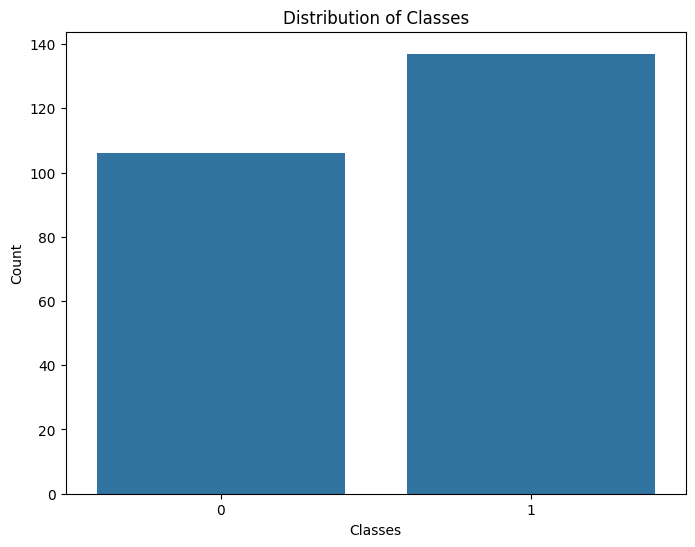

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Classes")
plt.title("Distribution of Classes")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

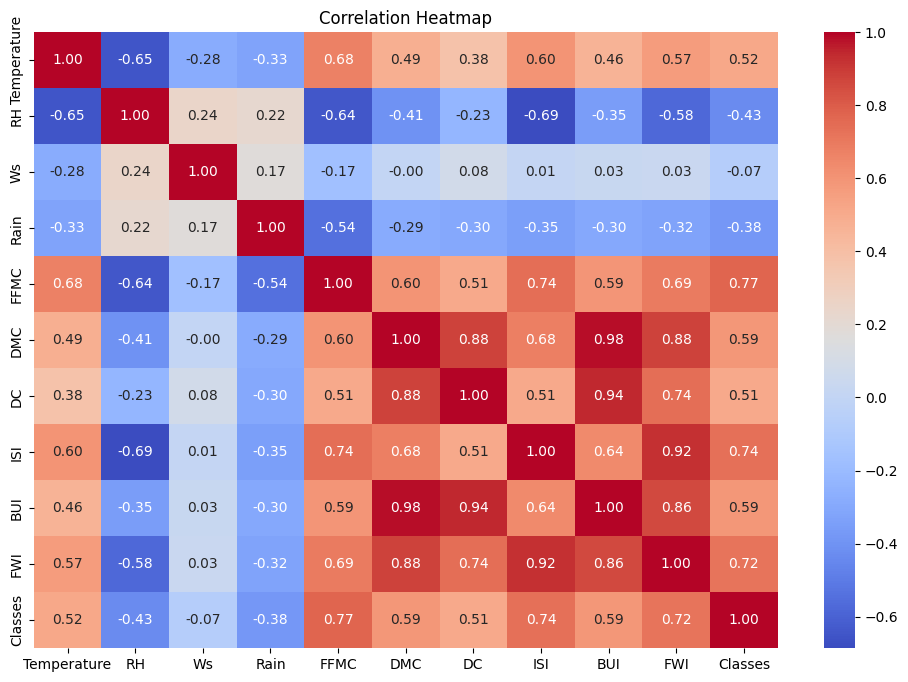

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Data Preparation

In [10]:
X = df.drop("Classes", axis=1)
y = df["Classes"]

In [11]:
X.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5


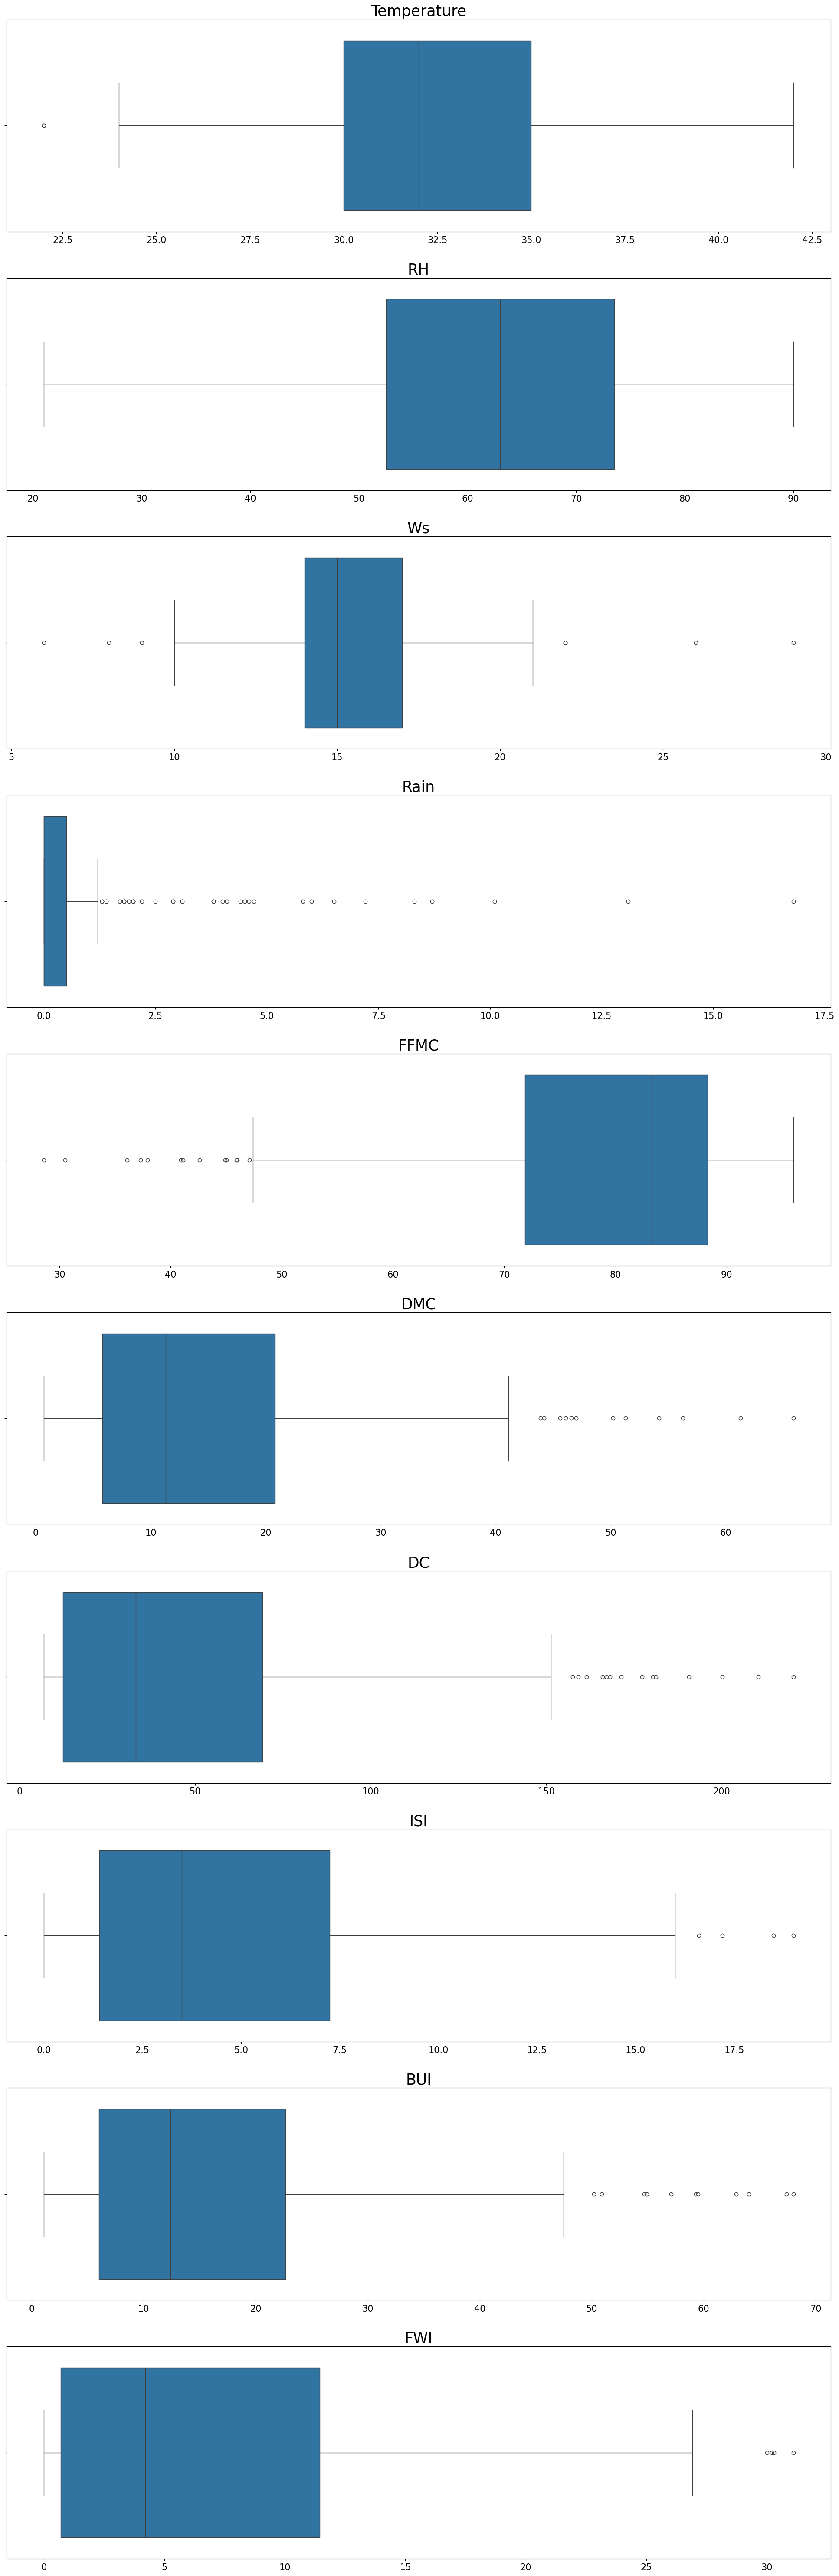

In [12]:
numerical_features = X

# Plot boxplots for all numerical features
fig, axs = plt.subplots(len(numerical_features.columns), 1, figsize=(20, 60))
axs = axs.flatten()

for idx, column_name in enumerate(numerical_features.columns):
    ax = axs[idx]
    sns.boxplot(x=numerical_features[column_name], ax=ax)
    ax.set_xlabel("")
    ax.set_title(column_name, fontsize=25)
    ax.set_ylabel("")
    ax.tick_params(axis="x", labelsize=15)

fig.tight_layout(pad=3.0)
plt.show()

In [13]:
from scipy.stats import zscore

# Compute z-scores for all numerical features
z = numerical_features.apply(zscore)


# A function to identify outlier locations based on a threshold
def outlier_locations(z, threshold):
    abs_z = np.abs(z)
    outlier_locs = np.where(abs_z > threshold)
    return outlier_locs


outlier_rows, outlier_cols = outlier_locations(z, threshold=3)
X.iloc[outlier_rows]

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
87,33,82,21,0.0,84.9,47.0,200.2,4.4,59.3,13.2
87,33,82,21,0.0,84.9,47.0,200.2,4.4,59.3,13.2
88,34,64,16,0.0,89.4,50.2,210.4,7.3,62.9,19.9
88,34,64,16,0.0,89.4,50.2,210.4,7.3,62.9,19.9
89,35,48,18,0.0,90.1,54.2,220.4,12.5,67.4,30.2
89,35,48,18,0.0,90.1,54.2,220.4,12.5,67.4,30.2
89,35,48,18,0.0,90.1,54.2,220.4,12.5,67.4,30.2
89,35,48,18,0.0,90.1,54.2,220.4,12.5,67.4,30.2


In [14]:
outlier_rows, outlier_cols = outlier_locations(z, threshold=4)
X.iloc[outlier_rows]

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
91,28,80,21,16.8,52.5,8.7,8.7,0.6,8.3,0.3
93,22,86,15,10.1,30.5,0.7,7.0,0.0,1.1,0.0
208,36,54,14,0.0,91.0,65.9,177.3,10.0,68.0,26.1
240,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2


In [15]:
# Define a function to drop outliers for both X and y
def drop_outliers(X, y, threshold):
    z = numerical_features.apply(zscore)
    outlier_rows, _ = outlier_locations(z, threshold=threshold)
    new_X = X.drop(outlier_rows, axis=0)
    new_y = y.drop(outlier_rows, axis=0)

    print(f"Before dropping outliers: X shape - {X.shape}, y shape - {y.shape}")
    print(f"After dropping outliers: X shape - {new_X.shape}, y shape - {new_y.shape}")

    return new_X, new_y


X, y = drop_outliers(X, y, threshold=4)

Before dropping outliers: X shape - (243, 10), y shape - (243,)
After dropping outliers: X shape - (238, 10), y shape - (238,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "std_scaler_weather.pkl")

['std_scaler_weather.pkl']

## Model Training

In [17]:
input_layer = Input(shape=(X_train.shape[1],))

x = Dense(128, activation="relu")(input_layer)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)

output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,649 (295.50 KB)

 Trainable params: 75,649 (295.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5318 - loss: 0.7011 - val_accuracy: 0.8750 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.5822 - val_accuracy: 0.8750 - val_loss: 0.4185 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7589 - loss: 0.5293 - val_accuracy: 0.8750 - val_loss: 0.2952 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8568 - loss: 0.3905 - val_accuracy: 0.9167 - val_loss: 0.1948 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8824 - loss: 0.2970 - val_accuracy: 0.9167 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9070 - loss: 0.2311 - val_accuracy: 0.9583 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9073 - loss: 0.2068 - val_accuracy: 0.95

## Model Evaluation

In [19]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0032
Test Loss: 0.0032225202303379774
Test Accuracy: 1.0


In [20]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [21]:
print(classification_report(y_test, y_pred, target_names=["not fire", "fire"]))

              precision    recall  f1-score   support

    not fire       1.00      1.00      1.00        10
        fire       1.00      1.00      1.00        14

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



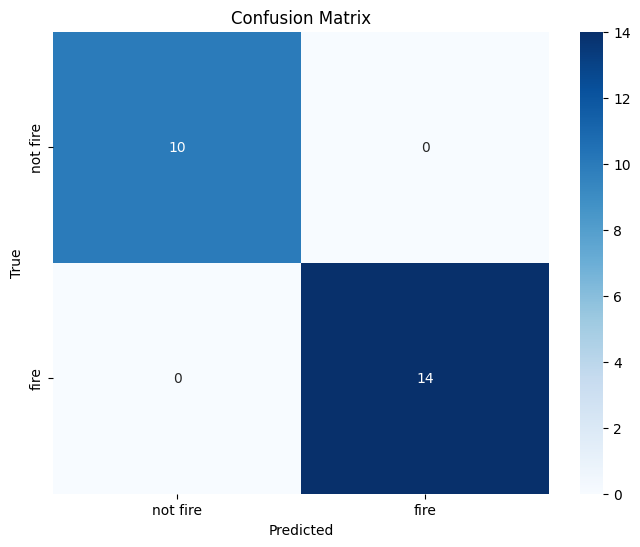

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["not fire", "fire"],
    yticklabels=["not fire", "fire"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [23]:
model.save("meteorological-detection-classification.keras")